In [9]:

import sys
import os
from pathlib import Path

import sys
import os
from pathlib import Path
parent_dir = os.path.dirname(os.getcwd())
sys.path.append(parent_dir)
sys.path.append("../models")
processed_series_path = Path(parent_dir) / 'processed_series'
# processed_series_path = Path(parent_dir) / '..' / 'llmICL' / 'processed_series'
import copy
from scipy.special import erf
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt
import pickle

print(sys.path)
from ICL import MultiResolutionPDF

def average_PDF_list(PDF_list, avg_interval = 6):
    """
    rolling average over a list of hierarchy PDFs
    """
    PDF_list_averaged = []
    common_bin_center_arr = PDF_list[0].bin_center_arr
    common_bin_width_arr = PDF_list[0].bin_width_arr
    for i in range(len(PDF_list)-avg_interval):
        avg_bin_height_arr = np.average([PDF_list[i+x].bin_height_arr for x in range(avg_interval)], axis = 0)
        avg_PDF = MultiResolutionPDF()
        avg_PDF.add_bin(common_bin_center_arr, common_bin_width_arr, avg_bin_height_arr)
        PDF_list_averaged += [avg_PDF]
    return PDF_list_averaged
        
def gaussian_manifold_generator(PDF_list, sigma_list, mean_list):
    """
        PDF_list: example PDF
    """
    assert len(sigma_list) == len(mean_list), "Sigma list and mean list must be of the same length"
    PDF_manifold_list = copy.deepcopy(PDF_list[:len(sigma_list)])
    for i, (sigma, mean) in enumerate(zip(sigma_list, mean_list)):
        def cdf(x):
            return 0.5 * (1 + erf((x - mean) / (sigma * np.sqrt(2))))
        PDF_manifold_list[i].discretize(cdf, mode = 'cdf')
        
    return PDF_manifold_list
    

def geodesic_from_true_stat(PDF_list, true_stat, geodesic_steps = 20, analytic_truth = True):
    """
        PDF_list: example PDF
        true_stat: statistics of true distribution
    """

    PDF_geodesic_list = copy.deepcopy(PDF_list[:geodesic_steps])
    PDF_ignorance = copy.deepcopy(PDF_list[0])
    def cdf(x):
        return np.clip(x / 10, 0, 1)
    PDF_ignorance.discretize(cdf, mode = "cdf")

    PDF_true = copy.deepcopy(PDF_list[-1])
    if analytic_truth:
        if true_stat['dist type'] == 'gaussian':
            def cdf(x):
                return 0.5 * (1 + erf((x - true_stat['rescaled_true_mean']) / (true_stat['rescaled_true_sigma'] * np.sqrt(2))))
        elif true_stat['dist type'] == 'uniform':
            low = true_stat['rescaled_true_mean'] - true_stat['rescaled_true_sigma']
            high = true_stat['rescaled_true_mean'] + true_stat['rescaled_true_sigma']
            def cdf(x):
                return np.where((x >= low) & (x <= high), (x - low) / (high - low), np.where(x < low, 0, 1))
        PDF_true.discretize(cdf, mode = "cdf")
    else:
        raise NotImplementedError()

    PDF_ignorance_sqrt = np.sqrt(PDF_ignorance.bin_height_arr)
    PDF_true_sqrt = np.sqrt(PDF_true.bin_height_arr)
    dG = np.arccos(1-PDF_true.Hel_dist(PDF_ignorance)**2/2)
    denom = np.sin(dG)
    for i in range(geodesic_steps):
        a = i/geodesic_steps
        u_coef = np.sin((1-a)*dG)/denom
        v_coef = np.sin(a*dG)/denom
        PDF_geodesic_list[i].bin_height_arr = np.square(u_coef * PDF_ignorance_sqrt + v_coef * PDF_true_sqrt)
    return PDF_geodesic_list        
    

['/home/admin-quad/Toni/LLMICL_inPCA/inPCA', '/home/admin-quad/anaconda3/envs/LLM/lib/python311.zip', '/home/admin-quad/anaconda3/envs/LLM/lib/python3.11', '/home/admin-quad/anaconda3/envs/LLM/lib/python3.11/lib-dynload', '', '/home/admin-quad/anaconda3/envs/LLM/lib/python3.11/site-packages', '/home/admin-quad/LLM/llama', '/home/admin-quad/Toni/LLMICL_inPCA', '../models', '/home/admin-quad/Toni/LLMICL_inPCA', '../models', '/home/admin-quad/Toni/LLMICL_inPCA', '../models']


In [10]:
all_files = sorted([path for path in processed_series_path.iterdir()], key=lambda x: x.name)
for index, file in enumerate(all_files):
    print(f"[{index}]: {file.name}")

[0]: brownian_motion_0.pkl
[1]: brownian_motion_1.pkl
[2]: brownian_motion_10.pkl
[3]: brownian_motion_11.pkl
[4]: brownian_motion_12.pkl
[5]: brownian_motion_13.pkl
[6]: brownian_motion_14.pkl
[7]: brownian_motion_15.pkl
[8]: brownian_motion_16.pkl
[9]: brownian_motion_17.pkl
[10]: brownian_motion_18.pkl
[11]: brownian_motion_19.pkl
[12]: brownian_motion_2.pkl
[13]: brownian_motion_3.pkl
[14]: brownian_motion_4.pkl
[15]: brownian_motion_5.pkl
[16]: brownian_motion_6.pkl
[17]: brownian_motion_7.pkl
[18]: brownian_motion_8.pkl
[19]: brownian_motion_9.pkl
[20]: correlated_gaussian_0.pkl
[21]: correlated_gaussian_1.pkl
[22]: correlated_gaussian_2.pkl
[23]: correlated_gaussian_3.pkl
[24]: correlated_gaussian_4.pkl
[25]: correlated_gaussian_5.pkl
[26]: correlated_gaussian_6.pkl
[27]: correlated_gaussian_7.pkl
[28]: correlated_gaussian_8.pkl
[29]: correlated_gaussian_9.pkl
[30]: geometric_brownian_motion_0.pkl
[31]: geometric_brownian_motion_1.pkl
[32]: geometric_brownian_motion_10.pkl
[33]:

In [12]:
alpha = 1
avg_interval = 3
PDF_slice = slice(0,200)
geodesic_steps = 20
gaussian_manifold = True

# uncorrelated gaussian, heterogeneous bin
# file = all_files[127] 
# file = all_files[128] 

# uncorrelated gaussian, uniform bin
# file = all_files[129] 
# file = all_files[130]  
# file = all_files[131] 
# file = all_files[132] 
# file = all_files[133] 

# file = all_files[134] 
# file = all_files[135] 
# file = all_files[136] 
# file = all_files[137] 

# narrow gaussian
# uncorrelated_gaussian_centered_sigma
# sigma 0.1
# file = all_files[139]
# file = all_files[140]
# file = all_files[141]
# file = all_files[142]
# file = all_files[143]

# sigma 0.3
# file = all_files[144]
# file = all_files[145]
# file = all_files[146]
# file = all_files[147]
# file = all_files[148]

PDF_list_multi_traj = []
true_statistics = []

# name = f"../figures/sigma_0.1_5_traj"
# name = f"../figures/sigma_0.3_5_traj"
# name = f"../figures/sigma_0.5_5_traj"
name = f"../figures/sigma_0.7_5_traj"
selected_files = [
                #   all_files[139], all_files[140], all_files[141], all_files[142], all_files[143],
                #   all_files[144], all_files[145], all_files[146], all_files[147], all_files[148],
                #   all_files[149], all_files[150], all_files[151], all_files[152], all_files[153],
                  all_files[154], all_files[155], all_files[156], all_files[157], all_files[158]
                ]

name = f"../figures/sigma_0.1_0.3_0.5_0.7_traj"
selected_files = [
                  all_files[139], #all_files[140], all_files[141],
                  all_files[144], #all_files[145], all_files[146]
                  all_files[149], #all_files[150], all_files[151],
                  all_files[154], #all_files[155], all_files[156]
                ]

name = f"../figures/uni_sigma_0.1_2_traj"
selected_files = [all_files[168], all_files[169]]

name = f"../figures/uni_sigma_0.1_0.3_0.5_0.7_traj"
# selected_files = [
#                   all_files[168],# all_files[169],# all_files[170], 
#                   all_files[174],# all_files[173],# all_files[175],
#                   all_files[178],# all_files[179], 
#                   all_files[183],# all_files[184], 
#                   ]

selected_files = [
                  all_files[168],# all_files[169],# all_files[170], 
                  all_files[174],# all_files[173],# all_files[175],
                  all_files[178],# all_files[179], 
                  all_files[183],# all_files[184], 
                  ]


for file in selected_files:
    processed_dict = pickle.load(file.open('rb'))
    PDF_list_multi_traj.append(processed_dict['PDF_list'])
    true_stat = {
        'dist type':  processed_dict.get('dist type', 'gaussian'), # if not specified, assume gaussian
        'rescaled_true_mean': processed_dict['rescaled_true_mean_arr'][-1],
        'rescaled_true_sigma': processed_dict['rescaled_true_sigma_arr'][-1]
    }
    true_statistics.append(true_stat)

# remove repeated true statistics
true_statistics = [dict(t) for t in {tuple(d.items()) for d in true_statistics}]
true_statistics



IndexError: index -1 is out of bounds for axis 0 with size 0

In [61]:
### tune temperature and sort by bin center
for PDF_list in PDF_list_multi_traj:
    for PDF in PDF_list:
        PDF.sort_by_center()
        if alpha != 1:
            PDF.rescale_temperature(alpha)
            
### average over steps
for i in range(len(PDF_list_multi_traj)):
    PDF_list_multi_traj[i] = average_PDF_list(PDF_list_multi_traj[i], avg_interval = avg_interval)

In [62]:
### Calculate geodesic 
PDF_geodesic_list_multi_traj = []
example_PDF_list = PDF_list_multi_traj[0]
for true_stat in true_statistics:
    PDF_geodesic_list_multi_traj += [geodesic_from_true_stat(example_PDF_list,
                                                             true_stat,
                                                             geodesic_steps=geodesic_steps)]

In [63]:
### Calculate gaussian sub-manifold:
if gaussian_manifold:
    # same length as geodesic, for easy plotting
    sigma_list = np.linspace(0,2,geodesic_steps)
    mean_list = np.array([5]*geodesic_steps)
    sub_manifold_list = gaussian_manifold_generator(PDF_list, sigma_list, mean_list)
    PDF_geodesic_list_multi_traj += [sub_manifold_list]
    
    %matplotlib inline 
    from ipywidgets import interact
    def plotter(idx):
        fig=plt.figure(figsize = (5,1))
        ax = fig.add_subplot(111)
        sub_manifold_list[idx].plot(ax=ax, statistic = False)

    interact(plotter, idx=(0, geodesic_steps-1, 1))

/tmp/ipykernel_219945/1559885076.py:44: RuntimeWarning: divide by zero encountered in divide
  return 0.5 * (1 + erf((x - mean) / (sigma * np.sqrt(2))))
/tmp/ipykernel_219945/1559885076.py:44: RuntimeWarning: invalid value encountered in divide
  return 0.5 * (1 + erf((x - mean) / (sigma * np.sqrt(2))))


interactive(children=(IntSlider(value=9, description='idx', max=19), Output()), _dom_classes=('widget-interact…

In [64]:
%matplotlib inline 
from ipywidgets import interact
def plotter(idx, traj_idx):
    PDF_geodesic_list = PDF_geodesic_list_multi_traj[traj_idx]
    fig=plt.figure(figsize = (5,1))
    ax = fig.add_subplot(111)
    PDF_geodesic_list[idx].plot(ax=ax, statistic = False)

interact(plotter, idx=(0, geodesic_steps-1, 1), traj_idx = (0,len(PDF_geodesic_list_multi_traj)-1, 1))


interactive(children=(IntSlider(value=9, description='idx', max=19), IntSlider(value=2, description='traj_idx'…

<function __main__.plotter(idx, traj_idx)>

In [65]:

traj_len = PDF_slice.stop - PDF_slice.start
PDF_emb_list = []
for PDF_list in PDF_list_multi_traj:
    PDF_emb_list += PDF_list[PDF_slice]

for i, geodesic_list in enumerate(PDF_geodesic_list_multi_traj):
    if i == 0:
        PDF_emb_list += geodesic_list
    else:
        PDF_emb_list += geodesic_list[1:]
        

### Compute pair-wise distance

In [66]:
import numpy as np

# Initialize the matrix D with zeros. The size of the matrix is determined by the length of PDF_list.
num_PDFs = len(PDF_emb_list)
D_Hel = np.zeros((num_PDFs, num_PDFs))
# Populate the upper triangle of the matrix with the BT distances.
for i in range(num_PDFs):
    for j in range(i+1, num_PDFs):  # Start from i+1 to avoid computing the distance of an object with itself
        D_Hel[i, j] = PDF_emb_list[j].Hel_dist(PDF_emb_list[i])

In [67]:
# Copy the upper triangle to the lower triangle to make the matrix symmetric.
# truncate
D_BT = -np.log(1-np.square(D_Hel)/2)
D_Hel = D_Hel + D_Hel.T
D_BT = D_BT + D_BT.T

P = np.eye(num_PDFs) - np.ones(num_PDFs)/num_PDFs
XXT_Hel = -P @ np.square(D_Hel) @ P
XXT_BT = -P @ D_BT @ P

### Hellinger Embedding

array([229.84801887,  73.42531751,  27.73446162])

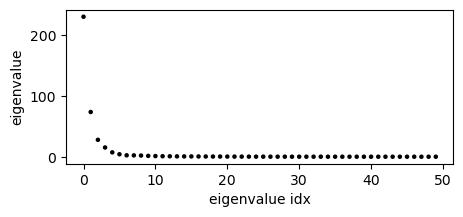

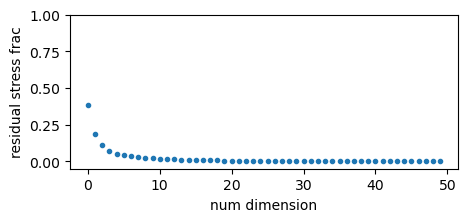

In [68]:
sigma, U = np.linalg.eigh(XXT_Hel)
# Reorder sigma and U based on the absolute value of sigma in decreasing order
idx = np.argsort(np.abs(sigma))[::-1]
sigma = sigma[idx]
U = U[:, idx]
U_rescaled = U * np.sqrt(np.abs(sigma))
# U_rescaled = U * sigma

%matplotlib inline 
# Plot with color based on the sign of sigma
spectrum_cutoff = 50
colors = ['black' if value > 0 else 'red' for value in sigma[:spectrum_cutoff]]
plt.figure(figsize=(5,2), dpi=100)
plt.scatter(range(spectrum_cutoff), np.abs(sigma[:spectrum_cutoff]), c=colors, s = 5)
plt.xlabel('eigenvalue idx')
plt.ylabel('eigenvalue')
# plt.yscale("log")

total_var = np.sum(np.abs(sigma))
explained_var = np.cumsum(np.abs(sigma))
plt.figure(figsize=(5,2), dpi=100)
plt.plot(1-explained_var[:50]/total_var, marker = '.', lw =0)
# plt.ylim(0,1.1)
# plt.yscale('log')
plt.xlabel('num dimension')
plt.ylabel('residual stress frac')
plt.ylim(-0.05,1)
sigma[:3]

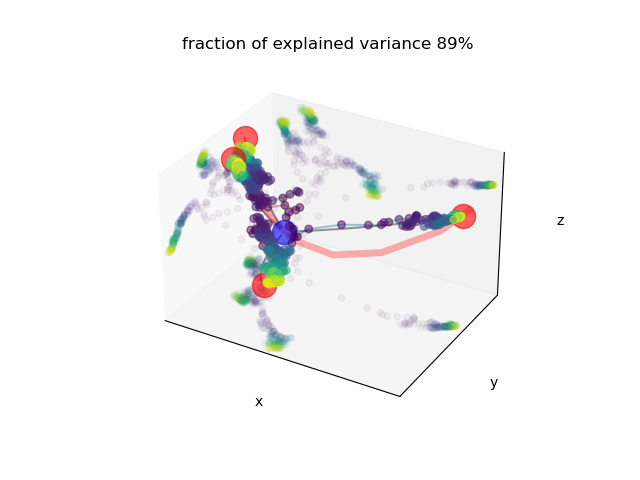

In [69]:
interactive = 1

time_cutoff = -geodesic_steps
interval = 1
geodesic = True
shadows = 1
shadow_alpha = 0.05
num_geodesics = len(PDF_geodesic_list_multi_traj)
num_trajs = len(PDF_list_multi_traj)

if interactive:
    #interactive 3D plot
    %matplotlib widget 
    fig = plt.figure(dpi = 100)
else:    
# static 3D plot
    %matplotlib inline 
    fig = plt.figure(dpi = 100, figsize=(8,8))
    
save_path = f"{name}_Hellinger_3D.png"
ax = fig.add_subplot(111, projection='3d')

# invert x axis
# U_rescaled[:,0] = -U_rescaled[:,0]
# invert z axis
U_rescaled[:,2] = -U_rescaled[:,2]
for i in range(num_trajs):
    # learning trajectories
    ax.scatter3D(U_rescaled[i*traj_len:(i+1)*traj_len:interval,0], U_rescaled[i*traj_len:(i+1)*traj_len:interval,1], U_rescaled[i*traj_len:(i+1)*traj_len:interval,2], c=range(int(traj_len/interval)), s = 30, alpha = 0.5)
    ax.plot(U_rescaled[i*traj_len:(i+1)*traj_len:interval,0], U_rescaled[i*traj_len:(i+1)*traj_len:interval,1], U_rescaled[i*traj_len:(i+1)*traj_len:interval,2], alpha = 0.4)

# ignorance is the shared
ign_index = num_trajs * traj_len
ax.scatter3D(U_rescaled[ign_index,0], U_rescaled[ign_index,1], U_rescaled[ign_index,2], c='blue', s = 300, alpha = 0.6)

for i in range(num_geodesics-gaussian_manifold):
    # geodesics
    start = ign_index+i*(geodesic_steps-1)+1
    end = ign_index+(i+1)*(geodesic_steps-1)+1
    ax.scatter3D(U_rescaled[end-1,0], U_rescaled[end-1,1], U_rescaled[end-1,2], c='red', s = 300, alpha = 0.6)
    if geodesic:
        ax.plot(U_rescaled[start : end,0], 
                U_rescaled[start : end,1],
                U_rescaled[start : end,2], c='black', alpha = 0.4)

if gaussian_manifold:
    # gaussian manifold
    start = ign_index+(num_geodesics-1)*(geodesic_steps-1)+1
    end = ign_index+num_geodesics*(geodesic_steps-1)+1
    ax.plot(U_rescaled[start : end,0], U_rescaled[start : end,1], U_rescaled[start : end,2], c='red', alpha = 0.3, lw = 5, label = "gaussian manifold")


if not interactive:
    ax.legend()
        
        
x_min, x_max = U_rescaled[:,0].min(), U_rescaled[:,0].max()
y_min, y_max = U_rescaled[:,1].min(), U_rescaled[:,1].max()
z_min, z_max = U_rescaled[:,2].min(), U_rescaled[:,2].max()
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.set_zlim(z_min, z_max)

if shadows:
    for zdir, zs, idx_tuple in zip(['x','y','z'],[x_min, y_max, z_min],[(1,2),(0,2),(0,1)]):        
        for i in range(len(PDF_list_multi_traj)):
            ax.scatter(U_rescaled[i*traj_len:(i+1)*traj_len:interval,idx_tuple[0]], U_rescaled[i*traj_len:(i+1)*traj_len:interval,idx_tuple[1]], c=range(int(traj_len/interval)), alpha = shadow_alpha, zs=zs, zdir=zdir)

    
ax.set_xticks([]) 
ax.set_yticks([]) 
ax.set_zticks([])

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

plt.title(f"fraction of explained variance {explained_var[2]/total_var*100:.0f}%")
# plt.axis('equal')
ax.set_aspect('equal')
if not interactive:
    plt.savefig(save_path)
plt.show()

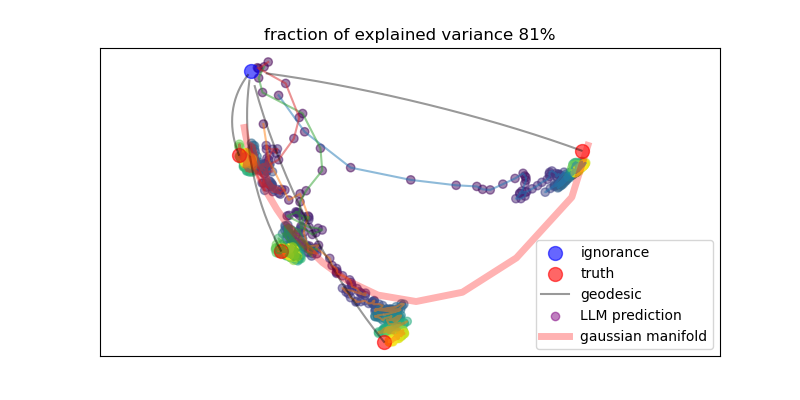

In [70]:
dim1 = 0
dim2 = 1
fig = plt.figure(dpi = 100, figsize=(8,4))
ax = fig.add_subplot(111)
for i in range(len(PDF_list_multi_traj)):    
    ax.scatter(U_rescaled[i*traj_len:(i+1)*traj_len:interval,dim1], U_rescaled[i*traj_len:(i+1)*traj_len:interval,idx_tuple[1]], c=range(int(traj_len/interval)), alpha = 0.5)
    ax.plot(U_rescaled[i*traj_len:(i+1)*traj_len:interval,dim1], U_rescaled[i*traj_len:(i+1)*traj_len:interval,idx_tuple[1]], alpha = 0.5)

# ignorance is the shared
ign_index = num_trajs * traj_len
ax.scatter(U_rescaled[ign_index,dim1], U_rescaled[ign_index,dim2], c='blue', s = 100, alpha = 0.6)

for i in range(num_geodesics-gaussian_manifold):
    # geodesics
    start = ign_index+i*(geodesic_steps-1)+1
    end = ign_index+(i+1)*(geodesic_steps-1)+1
    ax.scatter(U_rescaled[end-1,dim1], U_rescaled[end-1,dim2], c='red', s = 100, alpha = 0.6)
    if geodesic:
        ax.plot(U_rescaled[start : end,dim1], 
                U_rescaled[start : end,dim2], c='black', alpha = 0.4)


ax.scatter([],[], c='blue', s = 100, alpha = 0.6, label = 'ignorance')
ax.scatter([],[], c='red', s = 100, alpha = 0.6, label = 'truth')
if geodesic:
    ax.plot([], c='black', alpha=0.4, label = 'geodesic')
ax.scatter([],[], c='purple', alpha = 0.5, label = "LLM prediction")
  
if gaussian_manifold:
    # gaussian manifold
    start = ign_index+(num_geodesics-1)*(geodesic_steps-1)+1
    end = ign_index+num_geodesics*(geodesic_steps-1)+1
    ax.plot(U_rescaled[start : end,dim1], 
                U_rescaled[start : end,dim2], c='red', alpha = 0.3, lw = 5, label = "gaussian manifold")

plt.xticks([])  # Turn off x-axis ticks
plt.yticks([])  # Turn off y-axis ticks
plt.legend(loc = 'best')
plt.title(f"fraction of explained variance {explained_var[1]/total_var*100:.0f}%")
plt.axis('equal');
save_path = f"{name}_Hellinger_2D.png"
plt.savefig(save_path)

### Bhattacharyya Embedding

In [71]:
# sigma, U = np.linalg.eigh(XXT_BT)
# # Reorder sigma and U based on the absolute value of sigma in decreasing order
# idx = np.argsort(np.abs(sigma))[::-1]
# sigma = sigma[idx]
# U = U[:, idx]

# # U_rescaled = U * sigma
# # Plot with color based on the sign of sigma
# cutoff = 200
# colors = ['black' if value > 0 else 'red' for value in sigma[:cutoff]]
# plt.figure(figsize=(5,2), dpi=150)
# plt.scatter(range(cutoff), np.abs(sigma[:cutoff]), c=colors, s = 5)
# plt.xlabel('eigenvalue idx')
# plt.ylabel('eigenvalue')
# plt.yscale("log")

# total_var = np.sum(np.abs(sigma))
# explained_var = np.cumsum(np.abs(sigma))
# plt.figure(figsize=(5,2), dpi=150)
# plt.plot(1-explained_var[:50]/total_var, marker = '.', lw =0)
# # plt.ylim(0,1.1)
# # plt.yscale('log')
# plt.xlabel('num dimension')
# plt.ylabel('unexplained stress fraction')

In [72]:
# time_cutoff = 300
# interval = 10
# %matplotlib inline 
# save_path = f"../figures/{file.stem}_BT_2D.png"
# fig = plt.figure(dpi = 100, figsize=(8,4))

# dim1 = 0
# dim2 = 1

# plt.scatter(U_rescaled[:time_cutoff:interval,dim1], U_rescaled[:time_cutoff:interval,dim2], c=range(int(time_cutoff/interval)), alpha = 0.6)
# plt.plot(U_rescaled[:time_cutoff:interval,dim1], U_rescaled[:time_cutoff:interval,dim2], alpha = 0.2, label ="learning traj")

# plt.plot(U_rescaled[-geodesic_steps:,dim1], U_rescaled[-geodesic_steps:,dim2], alpha = 0.5, c='black', label ="geodesic")
# plt.scatter(U_rescaled[-1,dim1], U_rescaled[-1,dim2], c='red', s = 100, label ="truth", alpha = 0.6)
# plt.scatter(U_rescaled[-geodesic_steps,dim1], U_rescaled[-geodesic_steps,dim2], c='blue', s = 100, label ="ignorance", alpha = 0.6)

# plt.xticks([])  # Turn off x-axis ticks
# plt.yticks([])  # Turn off y-axis ticks
# plt.title(f"fraction of explained variance {explained_var[1]/total_var*100:.0f}%")
# plt.legend()
# plt.axis('equal');
# plt.savefig(save_path)



In [73]:
# time_cutoff = 120
# interval = 2

# interactive = 1
# shadows = 1
# shadow_alpha = 0.05
# if interactive:
#     #interactive 3D plot
#     %matplotlib widget 
#     fig = plt.figure(dpi = 100)
# else:    
# # static 3D plot
#     %matplotlib inline 
#     fig = plt.figure(dpi = 100, figsize=(8,8))
    
# save_path = f"../figures/{file.stem}_BT_3D.png"
# ax = fig.add_subplot(111, projection='3d')

# # invert x axis
# # U_rescaled[:,0] = -U_rescaled[:,0]
# ax.scatter3D(U_rescaled[:time_cutoff:interval,0], U_rescaled[:time_cutoff:interval,1], U_rescaled[:time_cutoff:interval,2], c=range(int(time_cutoff/interval)), s = 30, alpha = 0.8)
# ax.scatter3D(U_rescaled[-geodesic_steps,0], U_rescaled[-geodesic_steps,1], U_rescaled[-geodesic_steps,2], c='blue', s = 100, label ="ignorance", alpha = 0.6)
# ax.scatter3D(U_rescaled[-1,0], U_rescaled[-1,1], U_rescaled[-1,2], c='red', s = 100, label ="truth", alpha = 0.6)
# ax.plot(U_rescaled[:time_cutoff:interval,0], U_rescaled[:time_cutoff:interval,1],U_rescaled[:time_cutoff:interval,2], alpha = 0.4, label ="learning traj")
# ax.plot(U_rescaled[-geodesic_steps:,0], U_rescaled[-geodesic_steps:,1],U_rescaled[-geodesic_steps:,2], c='black', alpha = 0.4, label ="geodesic")
# ax.legend()


# x_min, x_max = U_rescaled[:,0].min(), U_rescaled[:,0].max()
# y_min, y_max = U_rescaled[:,1].min(), U_rescaled[:,1].max()
# z_min, z_max = U_rescaled[:,2].min(), U_rescaled[:,2].max()
# ax.set_xlim(x_min, x_max)
# ax.set_ylim(y_min, y_max)
# ax.set_zlim(z_min, z_max)

# if shadows:
#     # 2D projections
#     for zdir, zs, idx_tuple in zip(['x','y','z'],[x_min, y_max, z_min],[(1,2),(0,2),(0,1)]):
#         ax.plot(U_rescaled[:time_cutoff:interval,idx_tuple[0]], U_rescaled[:time_cutoff:interval,idx_tuple[1]], zdir=zdir, c = 'gray', alpha = shadow_alpha, zs=zs)
#         ax.scatter(U_rescaled[:time_cutoff:interval,idx_tuple[0]], U_rescaled[:time_cutoff:interval,idx_tuple[1]], zdir=zdir, c = range(int(time_cutoff/interval)), alpha = shadow_alpha, zs=zs)
        
#         ax.plot(U_rescaled[-geodesic_steps,idx_tuple[0]], U_rescaled[-geodesic_steps,idx_tuple[1]], zdir=zdir, c = 'blue', alpha = shadow_alpha, zs=zs, marker = 'o', markersize=10)
#         ax.plot(U_rescaled[-1,idx_tuple[0]], U_rescaled[-1,idx_tuple[1]], zdir=zdir, c = 'red', alpha = shadow_alpha, zs=zs, marker = 'o', markersize=10)
#         ax.plot(U_rescaled[-geodesic_steps:,idx_tuple[0]], U_rescaled[-geodesic_steps:,idx_tuple[1]], zdir=zdir, c = 'black', alpha = shadow_alpha, zs=zs)
        
    
# ax.set_xticks([]) 
# ax.set_yticks([]) 
# ax.set_zticks([])

# ax.set_xlabel('x')
# ax.set_ylabel('y')
# ax.set_zlabel('z')

# plt.title(f"fraction of explained variance {explained_var[2]/total_var*100:.0f}%")
# # plt.axis('equal')
# ax.set_aspect('equal')
# if not interactive:
#     plt.savefig(save_path)
# plt.show()